In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("data/PJM_Load_hourly.csv")
date_column='Datetime'
target_column='PJM_Load_MW'
data

,Datetime,PJM_Load_MW
0,1998-12-31 01:00:00,29309.0
1,1998-12-31 02:00:00,28236.0
2,1998-12-31 03:00:00,27692.0
3,1998-12-31 04:00:00,27596.0
4,1998-12-31 05:00:00,27888.0
...,...,...
32891,2001-01-01 20:00:00,35209.0
32892,2001-01-01 21:00:00,34791.0
32893,2001-01-01 22:00:00,33669.0
32894,2001-01-01 23:00:00,31809.0


## Pre Processing

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32896 entries, 0 to 32895
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Datetime     32896 non-null  object 
 1   PJM_Load_MW  32896 non-null  float64
dtypes: float64(1), object(1)
memory usage: 514.1+ KB


In [4]:
data.dropna(inplace=True)
data.isna().sum()

Datetime       0
PJM_Load_MW    0
dtype: int64

In [5]:
data.describe()

,PJM_Load_MW
count,32896.000000
mean,29766.427408
std,5849.769954
min,17461.000000
25%,25473.000000
50%,29655.000000
75%,33073.250000
max,54030.000000


## Normalization

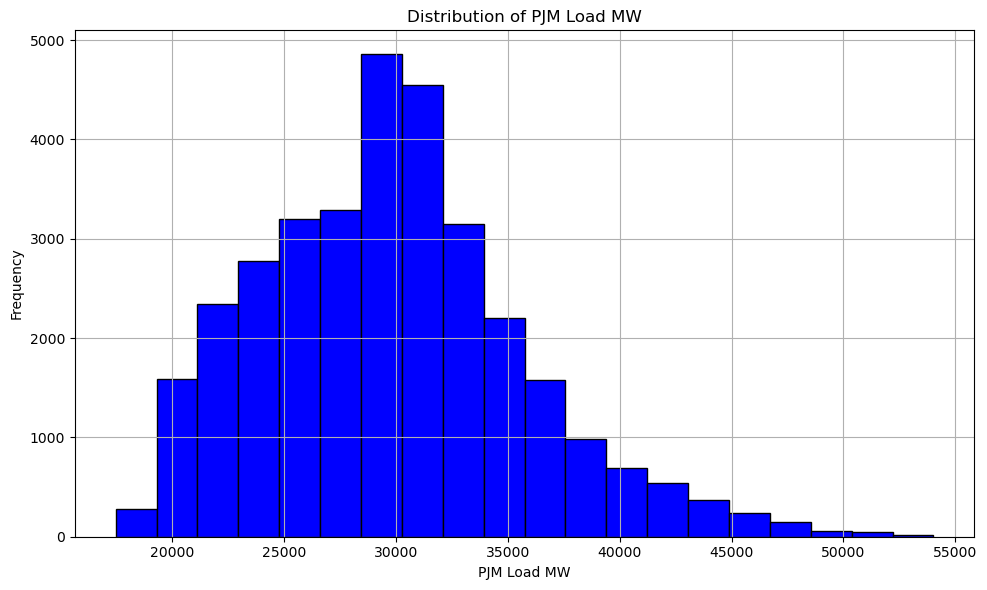

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(data[target_column], bins=20, color='blue', edgecolor='black')
plt.title('Distribution of PJM Load MW')
plt.xlabel('PJM Load MW')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
numerical_columns = [target_column]
data_to_normalize = data[numerical_columns]
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data_to_normalize)
normalized_df = pd.DataFrame(normalized_data, columns=numerical_columns)
normalized_df['Date'] = data[date_column]
normalized_df.head()

,PJM_Load_MW,Date
0,0.323990,1998-12-31 01:00:00
1,0.294648,1998-12-31 02:00:00
2,0.279772,1998-12-31 03:00:00
3,0.277147,1998-12-31 04:00:00
4,0.285132,1998-12-31 05:00:00


# Stationary Check

pValue of adfuller test is : 6.024269615128849e-27


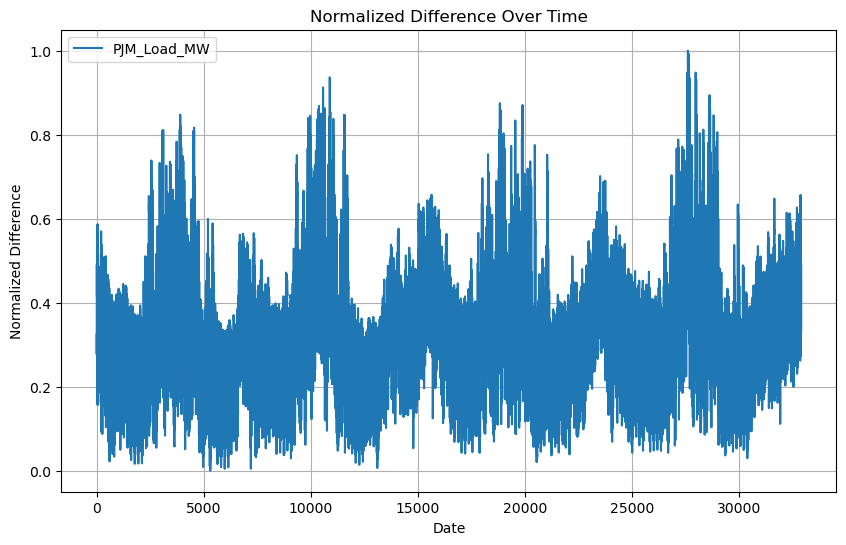

In [8]:
from statsmodels.tsa.stattools import adfuller
adftest=adfuller(normalized_df[target_column])
print('pValue of adfuller test is :',adftest[1])
plt.figure(figsize=(10, 6))
plt.plot(normalized_df.index, normalized_df[target_column], label=target_column)

plt.xlabel('Date')
plt.ylabel('Normalized Difference')
plt.title('Normalized Difference Over Time')
plt.legend()
plt.grid(True)
plt.show()

### Differencing

pValue of adfuller test is : 0.0


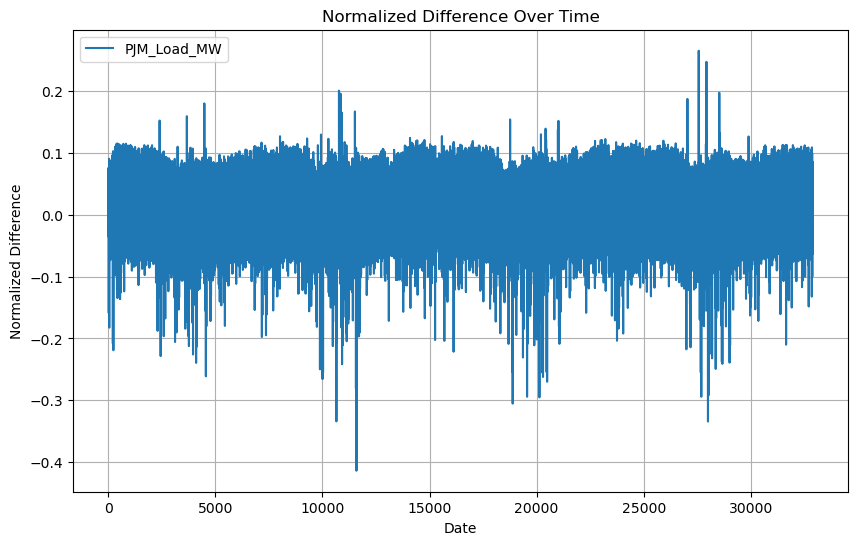

,PJM_Load_MW,Date
1,-0.029342,1998-12-31 02:00:00
2,-0.014876,1998-12-31 03:00:00
3,-0.002625,1998-12-31 04:00:00
4,0.007985,1998-12-31 05:00:00
5,0.040854,1998-12-31 06:00:00
...,...,...
32891,-0.007876,2001-01-01 20:00:00
32892,-0.011430,2001-01-01 21:00:00
32893,-0.030682,2001-01-01 22:00:00
32894,-0.050863,2001-01-01 23:00:00


In [9]:
normalized_difference=normalized_df.copy()
for column in numerical_columns:
    normalized_difference[f'{column}'] = normalized_difference[column].diff()
normalized_difference.dropna(inplace=True)
adftest=adfuller(normalized_difference[target_column])
print('pValue of adfuller test is :',adftest[1])
plt.figure(figsize=(10, 6))
plt.plot(normalized_difference.index, normalized_difference[target_column], label=target_column)

plt.xlabel('Date')
plt.ylabel('Normalized Difference')
plt.title('Normalized Difference Over Time')
plt.legend()
plt.grid(True)
plt.show()
normalized_difference

### Logarithim

pValue of adfuller test is : 6.95865393951138e-27


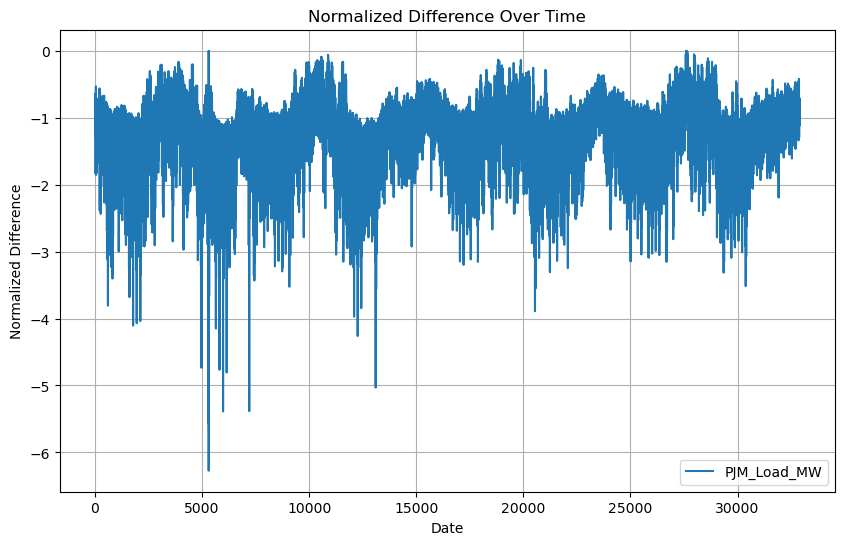

,PJM_Load_MW,Date
0,-1.127042,1998-12-31 01:00:00
1,-1.221972,1998-12-31 02:00:00
2,-1.273779,1998-12-31 03:00:00
3,-1.283206,1998-12-31 04:00:00
4,-1.254802,1998-12-31 05:00:00
...,...,...
32891,-0.722928,2001-01-01 20:00:00
32892,-0.746762,2001-01-01 21:00:00
32893,-0.813696,2001-01-01 22:00:00
32894,-0.935590,2001-01-01 23:00:00


In [10]:
normalized_log=normalized_df
for column in numerical_columns:
    normalized_log[f'{column}'] = normalized_log[column].apply(lambda x: np.log(x) if x != 0 else 0)
adftest=adfuller(normalized_log[target_column])
print('pValue of adfuller test is :',adftest[1]) 
normalized_log.dropna(inplace=True)
plt.figure(figsize=(10, 6))
plt.plot(normalized_log.index, normalized_log[target_column], label=target_column)

plt.xlabel('Date')
plt.ylabel('Normalized Difference')
plt.title('Normalized Difference Over Time')
plt.legend()
plt.grid(True)
plt.show()
normalized_log

### Breakdown for Stationary Data
Upon testing both difference and logarithmic method i have choosen Loagrithem method because the p value is less then 0.05

In [18]:
normalized_df=normalized_log
# normalized_df=normalized_difference
adftest=adfuller(normalized_df[target_column])
print('pValue of adfuller test is :',adftest[1]) 

pValue of adfuller test is : 6.95865393951138e-27


## Arima Model

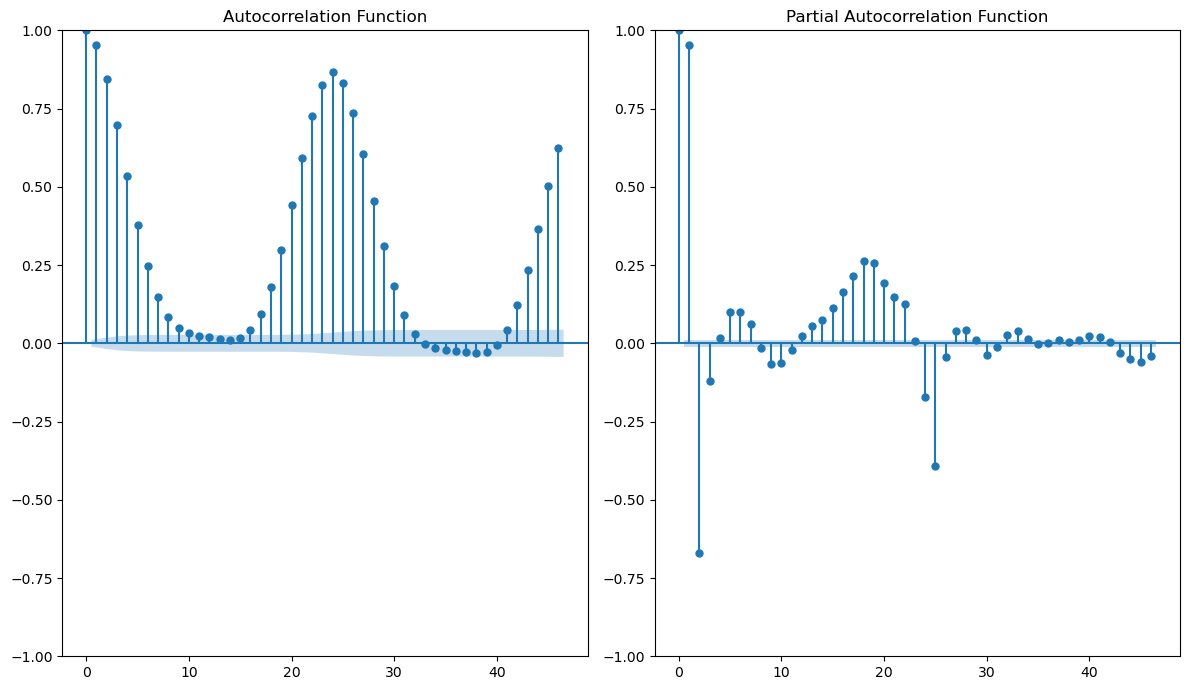

In [19]:
y = normalized_df[target_column]
lag_acf = acf(y, nlags=25)
lag_pacf = pacf(y, nlags=25, method='ols')
plt.figure(figsize=(12, 7))
plt.subplot(121)
plot_acf(y, ax=plt.gca())
plt.title('Autocorrelation Function')
plt.subplot(122)
plot_pacf(y, ax=plt.gca())
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()


In [20]:
dummy=normalized_df.copy()
dummy['Date'] = pd.to_datetime(dummy['Date'])
dummy.set_index('Date', inplace=True)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(dummy[target_column], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print("Adfuller Output")
dfoutput

Results of Dickey-Fuller Test:
Adfuller Output


Test Statistic                -1.445653e+01
p-value                        6.958654e-27
#Lags Used                     5.200000e+01
Number of Observations Used    3.284300e+04
dtype: float64

## Splitting

In [15]:
X = data.drop(columns=[date_column])
y = data[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

order = (1, 2, 0)  
model = ARIMA(y_train, order=order)
fitted_model = model.fit()

predictions = fitted_model.forecast(steps=len(X_test))

mse = ((predictions - y_test) ** 2).mean()
print("Mean Squared Error:", mse)

Mean Squared Error: 1656186326597.8892


In [17]:
import itertools
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)

param_combinations = list(itertools.product(p_values, d_values, q_values))
best_mse = float('inf')
best_params = None
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
for params in param_combinations:
    try:
        model = ARIMA(y_train, order=params)
        fitted_model = model.fit()
        predictions = fitted_model.forecast(steps=len(X_test))
        mse = mean_squared_error(y_test, predictions)
        if mse < best_mse:
            best_mse = mse
            best_params = params
    except:
        continue

print("Best parameters:", best_params)
print("Best Mean Squared Error:", best_mse)

Best parameters: (2, 1, 1)
Best Mean Squared Error: 33852989.35085012


In [93]:
model = ARIMA(train['Close'], order=(1, 2, 0))
arima_result = model.fit()
predictions_arima = arima_result.predict(start=test.index[0], end=test.index[-1])



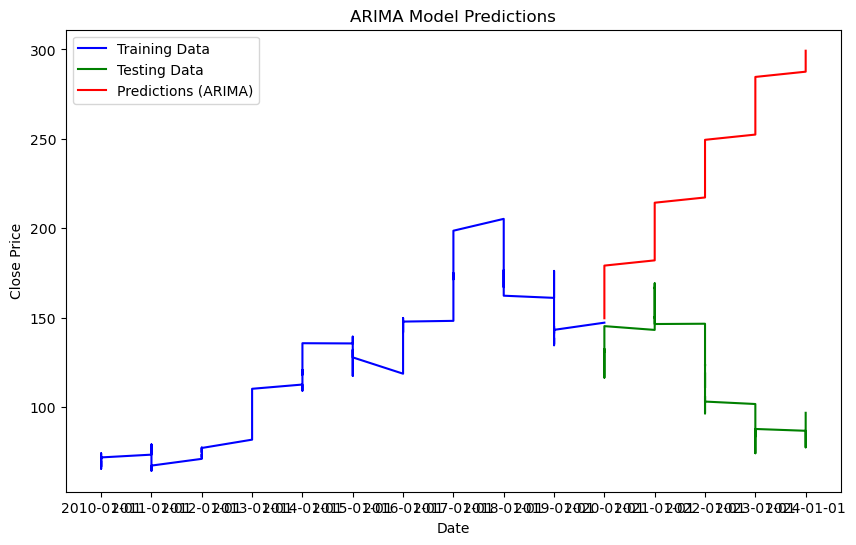

ARIMA Performance Metrics (Testing Set):
R-squared: -17.972755061486072
RMSE: 124.15863772991703
MAE: 103.95521247342913
MAPE: 107.166529677557


In [94]:
plt.figure(figsize=(10, 6))
plt.plot(train['Date'], train['Close'], label='Training Data', color='blue')
plt.plot(test['Date'], test['Close'], label='Testing Data', color='green')
plt.plot(test['Date'], predictions_arima, label='Predictions (ARIMA)', color='red')
plt.title('ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


predictions_arima_aligned = predictions_arima[:-1]

# Calculate evaluation metrics based on the testing set
rmse_arima = np.sqrt(mean_squared_error(test['Close'].iloc[1:], predictions_arima_aligned))
mae_arima = mean_absolute_error(test['Close'].iloc[1:], predictions_arima_aligned)
mape_arima = np.mean(np.abs((test['Close'].iloc[1:] - predictions_arima_aligned) / test['Close'].iloc[1:])) * 100
r_squared = r2_score(test['Close'].iloc[1:], predictions_arima_aligned)

# Print ARIMA performance metrics based on the testing set
print("ARIMA Performance Metrics (Testing Set):")
print("R-squared:", r_squared)
print("RMSE:", rmse_arima)
print("MAE:", mae_arima)
print("MAPE:", mape_arima)

In [26]:
# from tqdm import tqdm
# # Define a function to perform grid search
# def grid_search_ARIMA(y, p_values, d_values, q_values):
#     best_score = float('inf')
#     best_order = None
    
#     for p in tqdm(p_values, desc='Progress', position=0):
#         for d in d_values:
#             for q in q_values:
#                 order = (p, d, q)
#                 try:
#                     arima_model = ARIMA(y, order=order)
#                     arima_result = arima_model.fit()
#                     predictions = arima_result.predict()
#                     score = mean_absolute_error(y, predictions)
#                     if score < best_score:
#                         best_score = score
#                         best_order = order
#                 except:
#                     continue
    
#     return best_order, best_score

# p_values = range(0, 20)
# d_values = range(0, 5)
# q_values = range(0, 5)

# # Perform grid search
# best_order, best_score = grid_search_ARIMA(y, p_values, d_values, q_values)
# print("Best ARIMA Order:", best_order)
# print("Best MAE Score:", best_score)

Progress: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [08:52<00:00, 26.63s/it]

Best ARIMA Order: (18, 0, 3)
Best MAE Score: 0.013067150615045956


# ANN

In [31]:
X = normalized_df[date_column]
y = normalized_df[target_column]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
input_dim = X.shape[0]
model = Sequential()
model.add(Dense(64, input_dim=input_dim, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

loss = model.evaluate(X_test, y_test)
print('Test Loss:', loss)




Epoch 1/5


ValueError: in user code:

    File "C:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Input 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 172, but received input with shape (None, 1)
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 1), dtype=string)
      • training=True
      • mask=None


In [35]:
X.shape

(172,)